In [ ]:
#| default_exp model_embedding.semantic_deduplication

# Remove semantically similar images
> Remove semantically similar images from training dataset

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

In [ ]:
#| export
from cv_tools.core import *
from cv_tools.imports import *
from glob import glob


In [ ]:
#| export
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from typing import List
from PIL import Image
import torchvision.transforms as transforms
import h5py


In [ ]:
from private_front_easy_pin_detection.pytorch_model_development import UnetManualMaxPoolOnly

In [ ]:
import faiss

In [ ]:
DATA_PATH = os.getenv("DATA_PATH")
ROOT_PATH = Path(DATA_PATH, 'easy_front_pin_detection/curated_ds_224/trn')
IMAGE_PATHS = Path(ROOT_PATH, 'images')
MASK_PATHS = Path(ROOT_PATH, 'masks')
MODEL_FN="first_224_no_resize_best_val_0.9347_epoch_87.pth"
MODEL_PATH="/home/hasan/Schreibtisch/projects/data/easy_front_pin_detection/curated_ds_224/models/first_224_no_resize/first_224_no_resize"
MODEL_PATH_FULL = Path(MODEL_PATH, MODEL_FN)
#| export

In [ ]:
model = UnetManualMaxPoolOnly(
    in_channels=1,
    n_classes=1
)
checkpoint = torch.load(MODEL_PATH_FULL)
model.load_state_dict(
    checkpoint['model_state_dict'], 
)
model.to('cuda')
model.eval();

/tmp/ipykernel_3013003/4167734355.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH_FULL)


> installing faiss was a huge pain, but it works now
- conda install -c conda-forge faiss-gpu libblas=*=*mkl

In [ ]:
IMAGE_HIEGHT= 256
IMAGE_WIDTH = 256

In [ ]:
#| export
class ImageFeatureDataset(Dataset):
    def __init__(
            self, 
            image_paths: List[str], 
            transform=None, 
            IMAGE_HEIGHT=256, 
            IMAGE_WIDTH=256
        ):
        self.image_paths = image_paths
        self.transform = transform or transforms.Compose([
            transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
            transforms.ToTensor(),
            #transforms.Normalize(mean=[0.485], std=[0.229])
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')  # Convert to grayscale
        if self.transform:
            image = self.transform(image)
        return image, img_path

In [ ]:
# Load the UNet and modify it to only use the encoder
class EmbeddingModel(torch.nn.Module):
    def __init__(self, unet_model):
        super(EmbeddingModel, self).__init__()
        self.encoder = unet_model.encoder  # Use only the encoder

    def forward(self, x):
        c1, c2, c3, c4, c5 = self.encoder(x)  # Extract the deepest features
		# Global average pooling on the last feature map
        pooled = nn.AdaptiveAvgPool2d((1, 1))(c5)
        return pooled.view(pooled.size(0), -1)

In [ ]:
#| export
def extract_features(
    model: nn.Module,
    dataloader: DataLoader,
    device: torch.device,
    feature_dim: int = 256
) -> Tuple[np.ndarray, List[str]]:
    """Extract features from images using the encoder."""
    features = np.zeros((len(dataloader.dataset), feature_dim), dtype=np.float32)
    paths = []
    
    model.eval()
    with torch.no_grad():
        for idx, (batch, batch_paths) in enumerate(tqdm(dataloader, desc="Extracting features")):
            batch = batch.to(device)
            batch_features = model(batch).cpu().numpy()
            
            start_idx = idx * dataloader.batch_size
            end_idx = start_idx + len(batch)
            features[start_idx:end_idx] = batch_features
            paths.extend(batch_paths)
    
    return features, paths

In [ ]:
#| export
def find_duplicates(
    features: np.ndarray,
    paths: List[str],
    similarity_threshold: float = 0.95
) -> Dict[str, List[str]]:
    """Find duplicate images using FAISS indexing."""
    # Normalize features for cosine similarity
    features = features.astype(np.float32)
    faiss.normalize_L2(features)
    
    # Create FAISS index
    index = faiss.IndexFlatIP(features.shape[1])  # Inner product for cosine similarity
    index.add(features)
    
    # Search for similar images
    similarities, indices = index.search(features, k=50)  # Get top 50 similar images
    
    # Group duplicates
    duplicates = {}
    processed = set()
    
    for i in range(len(features)):
        if i in processed:
            continue
            
        current_duplicates = []
        for j, sim in zip(indices[i], similarities[i]):
            if sim > similarity_threshold and i != j and j not in processed:
                current_duplicates.append(paths[j])
                processed.add(j)
                
        if current_duplicates:
            duplicates[paths[i]] = current_duplicates
            processed.add(i)
    
    return duplicates

In [ ]:
IMAGE_PATHS.ls()

(#2775) [Path('/home/hasan/Schreibtisch/projects/data/easy_front_pin_detection/curated_ds_224/trn/images/5_13_2_2024107131220165_1.png'),Path('/home/hasan/Schreibtisch/projects/data/easy_front_pin_detection/curated_ds_224/trn/images/4_23_1_202410802725334_2.png'),Path('/home/hasan/Schreibtisch/projects/data/easy_front_pin_detection/curated_ds_224/trn/images/4_9_1_202410716105993_3.png'),Path('/home/hasan/Schreibtisch/projects/data/easy_front_pin_detection/curated_ds_224/trn/images/5_6_1_2024105213015837_1.png'),Path('/home/hasan/Schreibtisch/projects/data/easy_front_pin_detection/curated_ds_224/trn/images/3_2_2_202410894823249_4.png'),Path('/home/hasan/Schreibtisch/projects/data/easy_front_pin_detection/curated_ds_224/trn/images/1_27_1_2024107131427435_2.png'),Path('/home/hasan/Schreibtisch/projects/data/easy_front_pin_detection/curated_ds_224/trn/images/4_9_2_2024104131820122_1.png'),Path('/home/hasan/Schreibtisch/projects/data/easy_front_pin_detection/curated_ds_224/trn/images/4_16_2

In [ ]:
ds=ImageFeatureDataset(glob(f'{IMAGE_PATHS}/*.png'))
len(ds)

2775

In [ ]:

dl = DataLoader(ds, batch_size=32, num_workers=4, pin_memory=True)
img, path = next(iter(dl))
img.shape

torch.Size([32, 1, 256, 256])

In [ ]:
model = EmbeddingModel(model)
model.to('cuda')
model.eval()
features, paths = extract_features(model, dl, 'cuda')

Extracting features:   0%|          | 0/87 [00:00<?, ?it/s]

In [ ]:
features.shape

(2775, 256)

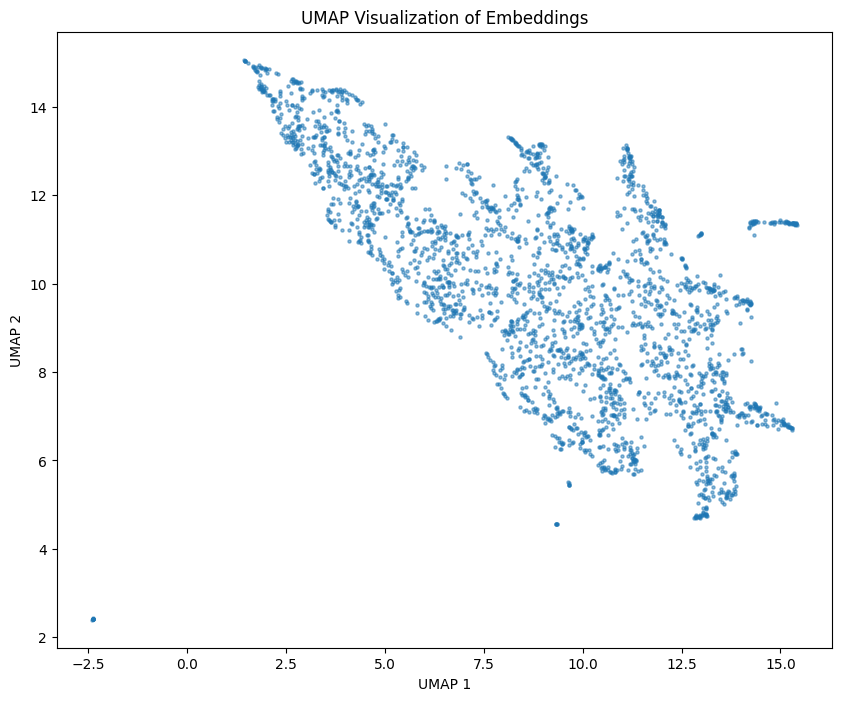

In [ ]:
import umap
import matplotlib.pyplot as plt

# Convert features to numpy array for UMAP
features_np = features

# Apply UMAP
reducer = umap.UMAP()
embedding = reducer.fit_transform(features_np)

# Plotting
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], s=5, alpha=0.5)
plt.title('UMAP Visualization of Embeddings')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

In [ ]:
#| export
class InteractiveUMAPViewer:
    def __init__(self, embeddings_path, image_folder, cache_dir=None):
        """
        Initialize the UMAP viewer
        embeddings_path: Path to H5 file containing embeddings
        image_folder: Path to folder containing images
        cache_dir: Optional path to cache UMAP results
        """
        self.image_folder = Path(image_folder)
        self.cache_dir = Path(cache_dir) if cache_dir else None
        
        # Load embeddings
        print("Loading embeddings...")
        with h5py.File(embeddings_path, 'r') as f:
            self.embeddings = np.array(f['embeddings'][:])
            self.image_paths = [p.decode('utf-8') for p in f['image_paths'][:]]
            
        # Initialize UMAP
        self.umap = UMAP(
            n_components=2,
            n_neighbors=15,
            min_dist=0.1,
            metric='euclidean',
            random_state=42
        )
        
    def compute_umap(self, force_recompute=False):
        """Compute UMAP embeddings with caching"""
        if self.cache_dir:
            cache_file = self.cache_dir / 'umap_cache.npy'
            
            if not force_recompute and cache_file.exists():
                print("Loading cached UMAP embeddings...")
                return np.load(cache_file)
        
        print("Computing UMAP embeddings (this might take a while)...")
        embeddings_2d = self.umap.fit_transform(self.embeddings)
        
        if self.cache_dir:
            self.cache_dir.mkdir(parents=True, exist_ok=True)
            np.save(cache_file, embeddings_2d)
            
        return embeddings_2d


In [ ]:
#| export
import numpy as np
from umap import UMAP
import plotly.graph_objects as go
from dash import Dash, dcc, html
from dash.dependencies import Input, Output
import base64
from PIL import Image
import io
from pathlib import Path
import h5py
from tqdm import tqdm
import json
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

class InteractiveUMAPViewer:
    def __init__(self, embeddings_path, image_folder, cache_dir=None):
        """
        Initialize the UMAP viewer
        embeddings_path: Path to H5 file containing embeddings
        image_folder: Path to folder containing images
        cache_dir: Optional path to cache UMAP results
        """
        self.image_folder = Path(image_folder)
        self.cache_dir = Path(cache_dir) if cache_dir else None
        
        # Load embeddings
        print("Loading embeddings...")
        with h5py.File(embeddings_path, 'r') as f:
            self.embeddings = np.array(f['embeddings'][:])
            self.image_paths = [p.decode('utf-8') for p in f['image_paths'][:]]
            
        # Initialize UMAP
        self.umap = UMAP(
            n_components=2,
            n_neighbors=15,
            min_dist=0.1,
            metric='euclidean',
            random_state=42
        )
        
    def compute_umap(self, force_recompute=False):
        """Compute UMAP embeddings with caching"""
        if self.cache_dir:
            cache_file = self.cache_dir / 'umap_cache.npy'
            
            if not force_recompute and cache_file.exists():
                print("Loading cached UMAP embeddings...")
                return np.load(cache_file)
        
        print("Computing UMAP embeddings (this might take a while)...")
        embeddings_2d = self.umap.fit_transform(self.embeddings)
        
        if self.cache_dir:
            self.cache_dir.mkdir(parents=True, exist_ok=True)
            np.save(cache_file, embeddings_2d)
            
        return embeddings_2d
        
    def create_app(self):
        """Create Dash app for interactive visualization"""
        app = Dash(__name__)
        
        # Compute UMAP
        embeddings_2d = self.compute_umap()
        
        # Create image cache for faster loading
        image_cache = {}
        
        app.layout = html.Div([
            html.Div([
                html.H1("Interactive UMAP Image Viewer", 
                        style={'textAlign': 'center'}),
                
                # Controls
                html.Div([
                    html.Label("Point Size:"),
                    dcc.Slider(
                        id='point-size',
                        min=1,
                        max=10,
                        value=5,
                        marks={i: str(i) for i in range(1, 11)},
                        step=0.5
                    ),
                    
                    html.Label("Point Opacity:"),
                    dcc.Slider(
                        id='point-opacity',
                        min=0.1,
                        max=1.0,
                        value=0.6,
                        marks={i/10: str(i/10) for i in range(1, 11)},
                        step=0.1
                    ),
                ], style={'padding': '20px', 'backgroundColor': '#f8f9fa'}),
                
                # Main content
                html.Div([
                    dcc.Graph(
                        id='umap-scatter',
                        figure={
                            'data': [go.Scattergl(
                                x=embeddings_2d[:, 0],
                                y=embeddings_2d[:, 1],
                                mode='markers',
                                marker={
                                    'size': 5,
                                    'opacity': 0.6,
                                    'color': 'blue'
                                },
                                hoverinfo='none'
                            )],
                            'layout': go.Layout(
                                title='UMAP Visualization',
                                hovermode='closest',
                                template='plotly_white'
                            )
                        },
                        style={'height': '600px', 'width': '50%', 'display': 'inline-block'}
                    ),
                    
                    # Image display
                    html.Div([
                        html.Img(id='selected-image', style={
                            'maxHeight': '500px',
                            'maxWidth': '100%',
                            'marginTop': '20px'
                        }),
                        html.P(id='image-info', style={'textAlign': 'center'})
                    ], style={
                        'width': '45%',
                        'display': 'inline-block',
                        'verticalAlign': 'top',
                        'padding': '20px',
                        'textAlign': 'center'
                    })
                ])
            ])
        ])
        
        @app.callback(
            [Output('umap-scatter', 'figure'),
             Output('selected-image', 'src'),
             Output('image-info', 'children')],
            [Input('umap-scatter', 'clickData'),
             Input('point-size', 'value'),
             Input('point-opacity', 'value')]
        )
        def update_figure_and_image(clickData, point_size, point_opacity):
            # Update scatter plot
            fig = {
                'data': [go.Scattergl(
                    x=embeddings_2d[:, 0],
                    y=embeddings_2d[:, 1],
                    mode='markers',
                    marker={
                        'size': point_size,
                        'opacity': point_opacity,
                        'color': 'blue'
                    },
                    hoverinfo='none'
                )],
                'layout': go.Layout(
                    title='UMAP Visualization',
                    hovermode='closest',
                    template='plotly_white'
                )
            }
            
            # Handle image display
            if clickData is None:
                return fig, '', 'Click a point to view the corresponding image'
                
            point_index = clickData['points'][0]['pointIndex']
            image_path = self.image_folder / self.image_paths[point_index]
            
            # Cache image encoding
            if str(image_path) not in image_cache:
                img = Image.open(image_path)
                buffered = io.BytesIO()
                img.save(buffered, format="JPEG")
                img_str = base64.b64encode(buffered.getvalue()).decode()
                image_cache[str(image_path)] = img_str
            
            img_src = f'data:image/jpeg;base64,{image_cache[str(image_path)]}'
            return fig, img_src, f'Image: {image_path.name}'
            
        return app
#
#def main():
    #"""
    #Example usage:
    #viewer = InteractiveUMAPViewer(
        #embeddings_path='embeddings.h5',
        #image_folder='path/to/images',
        #cache_dir='cache'
    #)
    #app = viewer.create_app()
    #app.run_server(debug=True)
    #"""
    #pass

#if __name__ == '__main__':
    #main()

In [ ]:
duplicates = find_duplicates(features, paths, 0.95)
len(duplicates)
#| export

156

In [ ]:
#| export
def process_images(
    image_dir: str,
    output_dir: str,
    batch_size: int = 32,
    similarity_threshold: float = 0.95
) -> Tuple[Dict[str, List[str]], int]:
    """Main function to process images and find duplicates."""
    # Setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image_paths = [str(p) for p in Path(image_dir).glob("**/*") if p.suffix.lower() in {'.jpg', '.jpeg', '.png'}]
    
    # Initialize model
    encoder = UnetManualMaxPoolOnly(in_channels=1, both_pool=False)
    feature_extractor = EmbeddingModel(encoder).to(device)
    
    # Create dataloader
    dataset = ImageFeatureDataset(image_paths)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=4, pin_memory=True)
    
    # Extract features
    features, paths = extract_features(feature_extractor, dataloader, device)

	# Find duplicates
    duplicates = find_duplicates(features, paths, similarity_threshold)
    
    # Create output directory structure
    os.makedirs(output_dir, exist_ok=True)
    unique_dir = os.path.join(output_dir, "unique")
    duplicate_dir = os.path.join(output_dir, "duplicates")
    os.makedirs(unique_dir, exist_ok=True)
    os.makedirs(duplicate_dir, exist_ok=True)
    
    # Move files
    processed_count = 0
    for original, duplicate_list in duplicates.items():
        # Copy original to unique folder
        shutil.copy2(original, unique_dir)
        
        # Copy duplicates to duplicate folder
        for dup in duplicate_list:
            shutil.copy2(dup, duplicate_dir)
            processed_count += 1
    
    return duplicates, processed_count

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export('19_model_embedding.semantic_deduplication.ipynb')